In [2]:
import sys
sys.path.append('..')

from scripts.autoencoders import InMemoryImageDataset, split_images, ConfigurableAutoencoder

import pandas as pd
from PIL import Image
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import cv2
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

In [3]:
try:
    OmegaConf.register_new_resolver("eval", eval)
except ValueError:
    pass

In [4]:
def load_tiff_datasets(carpeta):
    carpeta_archivos = f"C:/Users/Bianca/Documents/Archivos/ITBA/Tesis_Maestria/SAR_despeckling_filters_dataset/Main_folder/{carpeta}/"
    archivos_tiff = [f for f in os.listdir(carpeta_archivos) if f.endswith('.tiff')]

    num_imagenes = len(archivos_tiff)
    array_final = np.empty((num_imagenes, 512, 512), dtype=np.uint8)

    for i, archivo in enumerate(archivos_tiff):
        imagen = Image.open(os.path.join(carpeta_archivos, archivo))
        array_imagen = np.array(imagen)[:, :, 0]
        array_final[i] = array_imagen
        
        if (i+1) % 250 == 0:
            print(f'{i+1} de {num_imagenes} imágenes procesadas')

    print(f'\nArray final shape: {array_final.shape}')
    print(f'Máximo valor: {array_final.max()}, mínimo valor: {array_final.min()}')
    
    return array_final

In [5]:
noisy = load_tiff_datasets('Noisy')

250 de 1500 imágenes procesadas
500 de 1500 imágenes procesadas
750 de 1500 imágenes procesadas
1000 de 1500 imágenes procesadas
1250 de 1500 imágenes procesadas
1500 de 1500 imágenes procesadas

Array final shape: (1500, 512, 512)
Máximo valor: 255, mínimo valor: 0


In [6]:
noisy_val = load_tiff_datasets('Noisy_val')


Array final shape: (100, 512, 512)
Máximo valor: 255, mínimo valor: 0


In [7]:
clean = load_tiff_datasets('GTruth')

250 de 1500 imágenes procesadas
500 de 1500 imágenes procesadas
750 de 1500 imágenes procesadas
1000 de 1500 imágenes procesadas
1250 de 1500 imágenes procesadas
1500 de 1500 imágenes procesadas

Array final shape: (1500, 512, 512)
Máximo valor: 255, mínimo valor: 0


In [8]:
clean_val = load_tiff_datasets('GTruth_val')


Array final shape: (100, 512, 512)
Máximo valor: 255, mínimo valor: 0


In [9]:
clean = clean[np.array([np.min(img) != np.max(img) for img in clean])]
noisy = noisy[np.array([np.min(img) != np.max(img) for img in noisy])]
print(clean.shape)
print(noisy.shape)

(1487, 512, 512)
(1487, 512, 512)


In [10]:
clean_val = clean_val[np.array([np.min(img) != np.max(img) for img in clean_val])]
noisy_val = noisy_val[np.array([np.min(img) != np.max(img) for img in noisy_val])]
print(clean_val.shape)
print(noisy_val.shape)

(100, 512, 512)
(100, 512, 512)


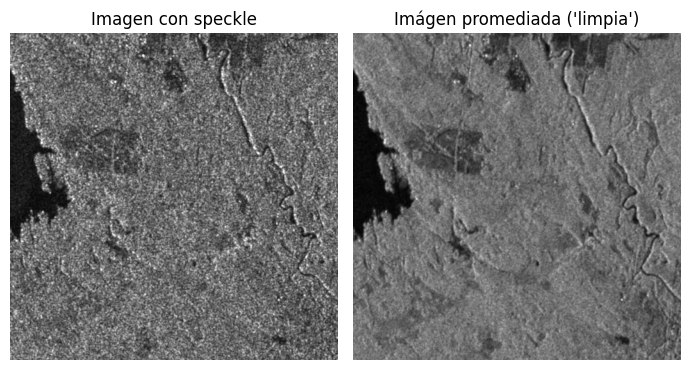

In [11]:
index = 450 # Index random

plt.figure(figsize=(7, 4))

plt.subplot(1, 2, 1)
plt.imshow(noisy[index], cmap='gray')
plt.title("Imagen con speckle")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(clean[index], cmap='gray')
plt.title("Imágen promediada ('limpia')")
plt.axis('off')

plt.tight_layout()
plt.show()

---
Elegir el archivo de configuración correspondiente:

In [12]:
config_name = 'config_1' # Elegir

config_path = f'configs/imagenes_reales/{config_name}.yaml'
config = OmegaConf.load(config_path)
config

{'training': {'num_epochs': 250, 'batch_size': 64, 'learning_rate': 0.001, 'scheduler_name': 'elr', 'scheduler_params': {'gamma': 0.95}, 'side_size': 512}, 'model': {'encoding_dim': 1600, 'loss_function': 'mse', 'optimizer': 'adam'}, 'encoder': {'layers': [{'type': 'conv2d', 'filters': 8, 'kernel_size': 8, 'stride': 4, 'padding': 2, 'activation': 'relu'}, {'type': 'conv2d', 'filters': 16, 'kernel_size': 8, 'stride': 4, 'padding': 2, 'activation': 'relu'}, {'type': 'flatten'}, {'type': 'dense', 'dim': '${model.encoding_dim}', 'activation': 'relu'}]}, 'decoder': {'layers': [{'type': 'dense', 'dim': 16384, 'activation': 'relu'}, {'type': 'unflatten', 'dim1': 32, 'dim2': 32, 'out_channels': 16}, {'type': 'conv2d_transpose', 'filters': 8, 'kernel_size': 8, 'stride': 4, 'padding': 2, 'activation': 'relu'}, {'type': 'conv2d_transpose', 'filters': 1, 'kernel_size': 8, 'stride': 4, 'padding': 2, 'activation': 'sigmoid'}]}, 'testing': {'batch_size': 32}}

---
# Creación del dataset para entrenar

In [13]:
batch_size = config['training']['batch_size']

In [ ]:
if (
    not isinstance(config['training']['side_size'], int)
    or config['training']['side_size'] <= 0
    or config['training']['side_size'] > clean.shape[1]
):
    raise ValueError(
        f"side_size debe ser un entero positivo y menor o igual al número de píxeles por lado de las imágenes ({clean.shape[1]}). "
        f"Se recibió side_size = {config['training']['side_size']}."
    )

In [16]:
if config['training']['side_size'] == 512:
    pass

else:
    clean = split_images(clean, config['training']['side_size'])
    noisy = split_images(noisy, config['training']['side_size'])    
    
    clean = clean[np.array([np.min(img) != np.max(img) for img in clean])]
    noisy = noisy[np.array([np.min(img) != np.max(img) for img in noisy])]
    
print(clean.shape)
print(noisy.shape)

(1487, 512, 512)
(1487, 512, 512)


In [13]:
# noisy = GI0
# clean = GI

normalize_to_01 = transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_to_01
])

dataset_train = InMemoryImageDataset(noisy, clean, transform=transform)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

---
# Entrenamiento

In [14]:
num_epochs = config['training']['num_epochs']
learning_rate = config['training']['learning_rate']
scheduler_name = config['training'].get('scheduler_name')

In [15]:
autoencoder = ConfigurableAutoencoder(config=config, image_size=noisy.shape[1])
autoencoder

ConfigurableAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=16384, out_features=1600, bias=True)
    (6): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1600, out_features=16384, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(16, 32, 32))
    (3): ConvTranspose2d(16, 8, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(8, 1, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (6): Sigmoid()
  )
)

In [16]:
summary(
    autoencoder,
    (1, noisy.shape[1], noisy.shape[2]) # (nro_de_canales, alto, ancho) de las imágenes de entrada
)
# El -1 que se ve en la primera posición de todos los output shapes es un placeholder para el tamaño del batch

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             520
              ReLU-2          [-1, 8, 128, 128]               0
            Conv2d-3           [-1, 16, 32, 32]           8,208
              ReLU-4           [-1, 16, 32, 32]               0
           Flatten-5                [-1, 16384]               0
            Linear-6                 [-1, 1600]      26,216,000
              ReLU-7                 [-1, 1600]               0
            Linear-8                [-1, 16384]      26,230,784
              ReLU-9                [-1, 16384]               0
        Unflatten-10           [-1, 16, 32, 32]               0
  ConvTranspose2d-11          [-1, 8, 128, 128]           8,200
             ReLU-12          [-1, 8, 128, 128]               0
  ConvTranspose2d-13          [-1, 1, 512, 512]             513
          Sigmoid-14          [-1, 1, 5

In [17]:
loss = config['model']['loss_function'].lower()
opt = config['model']['optimizer'].lower()

if loss == 'mse':
    criterion = nn.MSELoss()
elif loss == 'bce':
    criterion = nn.BCELoss()

if opt == 'adam':
    optimizer = optim.Adam(
        autoencoder.parameters(), 
        lr=learning_rate
    )
elif optim == 'sgd':
    optimizer = optim.SGD(
        autoencoder.parameters(), 
        lr=learning_rate,
        momentum=0.9
    )

In [18]:
if scheduler_name is None:
    pass

elif scheduler_name.lower() == "rlrop":
    # ReduceLROnPlateau - reduce el lr cuando el loss deja de mejorar
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode=config.training.scheduler_params.get('mode','min'),
        factor=config.training.scheduler_params.get('factor',0.1),   # Reduce el lr por este factor
        patience=config.training.scheduler_params.get('patience',5)  # Espera estas épocas antes de reducir
    )

elif scheduler_name.lower() == "slr":
    # StepLR - reduce el lr cada cierto número de épocas
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=config.training.scheduler_params.get('step_size',7),  # Cada step_size épocas
        gamma=config.training.scheduler_params.get('gamma',0.1)         # Reduce por este factor
    )

elif scheduler_name.lower() == "elr":
    # ExponentialLR - reduce el lr exponencialmente
    scheduler = torch.optim.lr_scheduler.ExponentialLR(
        optimizer,
        gamma=config.training.scheduler_params.get('gamma',0.95)  # Factor de reducción por época
    )

In [19]:
training_losses = []

for epoch in range(num_epochs):
    epoch_losses = []
    
    for data in train_loader:
        entrada, salida = data
        entrada = entrada.float()
        salida = salida.float()

        # Forward pass
        outputs = autoencoder(entrada) # Se pasa a las imágenes por el autoencoder, en una pasada forward.
        loss = criterion(outputs, salida) # Se calcula la diferencia entre el output y las imágenes sin ruido, según la función de pérdida definida.

        # Backward pass y optimización
        optimizer.zero_grad() # Se restablecen los gradientes acumulados en todos los parámetros del modelo.
                              # Esto es necesario antes de realizar el backward pass, ya que PyTorch acumula los gradientes en cada llamada a loss.backward().
        loss.backward() # Se realiza el backward pass para calcular los gradientes de los parámetros del autoencoder utilizando la función de pérdida.
        optimizer.step() # Finalmente se realiza la optimización de los parámetros del modelo mediante la llamada a optimizer.step(), que actualiza los parámetros en función de los gradientes calculados.

        epoch_losses.append(loss.item())
        
    avg_loss = np.mean(epoch_losses)
    training_losses.append(avg_loss)

    if scheduler_name is None:
        pass
    elif scheduler_name.lower() == "rlrop":
        scheduler.step(avg_loss)
        print(f"lr: {scheduler.get_last_lr()}")
    elif scheduler_name.lower() in ["slr", "elr"]:
        scheduler.step()
        print(f"lr: {scheduler.get_last_lr()}")
    
    # Imprimir la pérdida del autoencoder en cada época
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

lr: [0.00095]
Epoch [1/250], Loss: 0.0383


KeyboardInterrupt: 

In [ ]:
# Guardo los parámetros del modelo entrenado:
### torch.save(autoencoder.state_dict(), f'data/trained_models/imagenes_reales/{config_name}.pth')

In [ ]:
df_errors = pd.DataFrame({
    'epoch': range(1, num_epochs + 1),
    'loss': training_losses
})

### df_errors.to_csv(f'data/train_errors/imagenes_reales/{config_name}.csv', index=False)

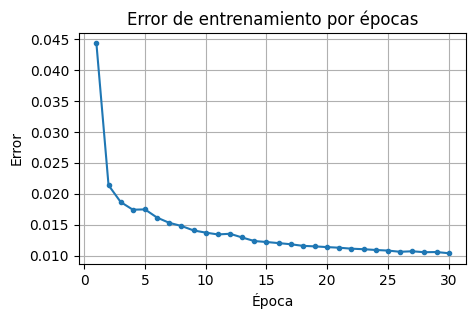

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, num_epochs + 1), training_losses, '.-')
plt.title('Error de entrenamiento por épocas')
plt.xlabel('Época')
plt.ylabel('Error')
plt.grid()

---
# Evaluación

In [ ]:
autoencoder.eval() # Para desactivar Dropout, BatchNorm, etc.
batch_size = config['testing']['batch_size']

In [ ]:
if config['training']['side_size'] == 512:
    pass

else:
    clean_val = split_images(clean_val, config['training']['side_size'])
    noisy_val = split_images(noisy_val, config['training']['side_size'])    
    
    clean_val = clean_val[np.array([np.min(img) != np.max(img) for img in clean_val])]
    noisy_val = noisy_val[np.array([np.min(img) != np.max(img) for img in noisy_val])]
    
print(clean_val.shape)
print(noisy_val.shape)

In [26]:
dataset_test = InMemoryImageDataset(noisy_val, clean_val, transform=transform)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [27]:
total_loss = 0
with torch.no_grad(): # Esto es para asegurarse de que no se realicen cálculos de gradientes durante la evaluación del autoencoder.
                      # Al entrar en este bloque, se desactiva el cálculo y almacenamiento automático de gradientes para reducir el uso de memoria y acelerar la evaluación.
    for data in test_loader:
        entrada, salida = data
        entrada = entrada.float()
        salida = salida.float()

        # Forward pass
        outputs = autoencoder(entrada) # Se realiza el forward pass del autoencoder con las imágenes de prueba.
                                       # El autoencoder genera las imágenes reconstruidas utilizando el método forward() que definimos previamente en la clase Autoencoder.
        loss = criterion(outputs, salida) # Se calcula la pérdida entre las imágenes reconstruidas y las imágenes originales utilizando la función de pérdida (criterion).
                                          # Esto proporciona una medida de cuánto difieren las imágenes reconstruidas de las originales.
        total_loss += loss.item() # La pérdida obtenida en cada iteración se suma a la variable total_loss utilizando loss.item(), que devuelve el valor escalar de la pérdida.
                                  # Al final de la iteración, total_loss contendrá la suma acumulada de las pérdidas de todas las muestras del conjunto de datos de prueba.

average_loss = total_loss / len(test_loader) # Se calcula la pérdida promedio dividiendo la suma acumulada de las pérdidas (total_loss) entre el número de lotes en el conjunto de datos de prueba (len(test_loader)).
                                             # Esto proporciona una medida promedio de la discrepancia entre las imágenes originales y las imágenes reconstruidas por el autoencoder en el conjunto de datos de prueba.
print(f"Average Test Loss: {average_loss:.4f}")

Average Test Loss: 0.0221


In [28]:
test_file_path = f'data/test_errors_imagenes_reales.csv'

new_result = pd.DataFrame({
    'config_name': [config_name],
    'loss_testing': [average_loss]
})

try:
    existing_results = pd.read_csv(test_file_path)
    existing_results = existing_results[existing_results['config_name'] != config_name]
    all_results = pd.concat([existing_results, new_result], ignore_index=True)
except FileNotFoundError:
    all_results = new_result

### all_results.to_csv(test_file_path, index=False)

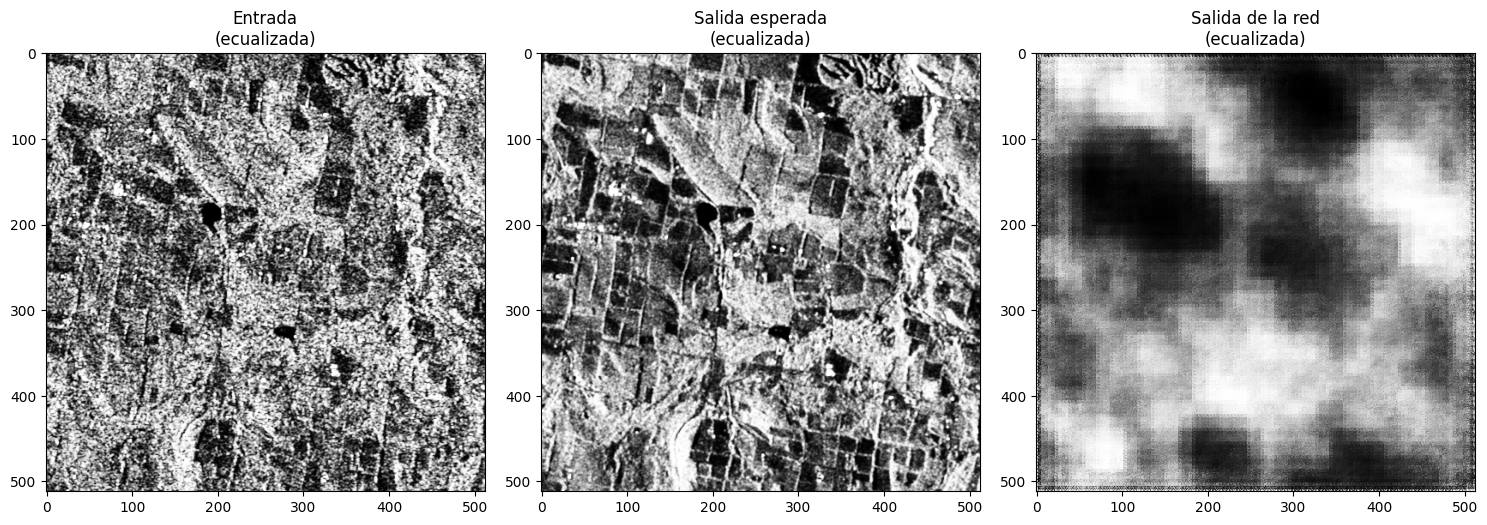

In [29]:
# Aplico el autoencoder a un ejemplo particular del dataset de testeo y veo cómo queda la
# imagen de salida.

ecualizar_hist = True  # Si se quiere o no ecualizar el histograma de la imagen

###

def graph_random_image(ecualizar_hist, name_suffix, show_plot=True):

    index = int(noisy_val.shape[0]*np.random.random()) # Índice del ejemplo puntual que se desea seleccionar
    entrada_red, salida_red = dataset_test[index]

    example = entrada_red.float().unsqueeze(0)

    reconstructed = autoencoder(example) # Aplica el autoencoder al ejemplo

    tamanio = noisy_val.shape[1]

    entrada = entrada_red.view(tamanio, tamanio)
    salida_esperada = salida_red.view(tamanio, tamanio)
    reconstructed = reconstructed.view(tamanio, tamanio)

    imagenes = [entrada, salida_esperada, reconstructed.detach()]
    titulos = ['Entrada', 'Salida esperada', 'Salida de la red']

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, imagen, titulo in zip(axes, imagenes, titulos):
        if ecualizar_hist:
            im = imagen.cpu().numpy()
            im = ((im - im.min()) * 255) / (im.max() - im.min())
            imagen = cv2.equalizeHist(im.astype(np.uint8))
            titulo += '\n(ecualizada)'
        
        ax.imshow(imagen, cmap='gray')
        ax.set_title(titulo)

    plt.tight_layout()
    ### plt.savefig(f'data/images/imagenes_reales/{config_name}_{name_suffix}.png', dpi=300, bbox_inches='tight')

    if not show_plot:
        plt.close(fig)

    return imagenes, titulos

imagenes, titulos = graph_random_image(ecualizar_hist=ecualizar_hist, name_suffix=1, show_plot=True)

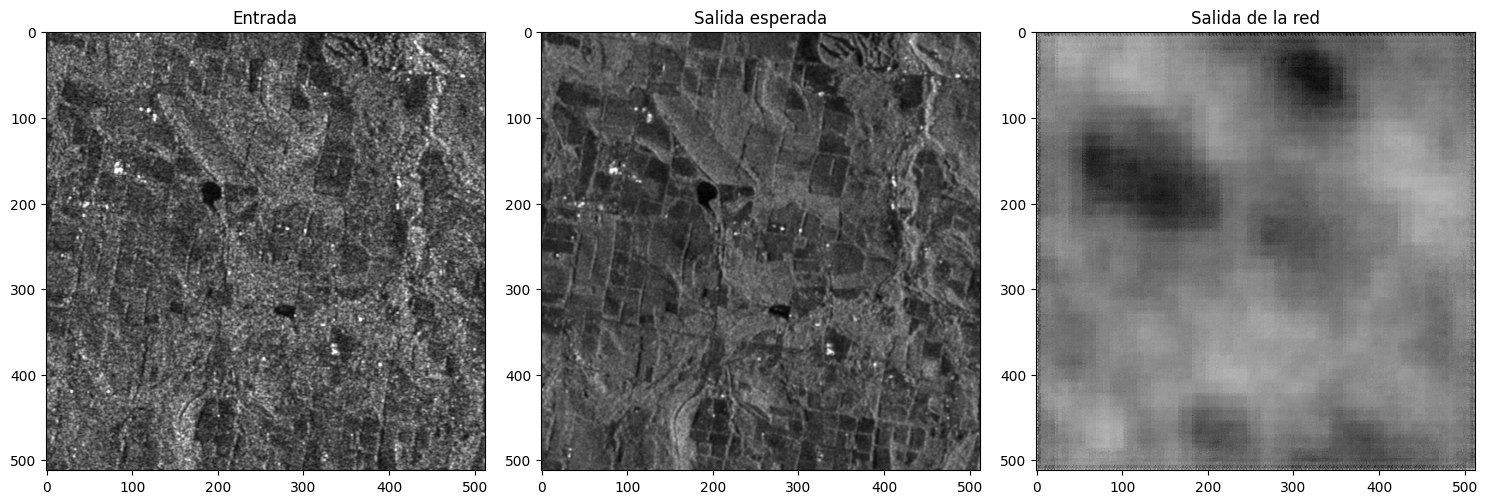

In [30]:
# Hago lo mismo que arriba, para la misma imagen, pero sin ecualizar

ecualizar_hist = False  # Si se quiere o no ecualizar el histograma de la imagen

###

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, imagen, titulo in zip(axes, imagenes, titulos):
    if ecualizar_hist:
        im = imagen.cpu().numpy()
        im = ((im - im.min()) * 255) / (im.max() - im.min())
        imagen = cv2.equalizeHist(im.astype(np.uint8))
        titulo += '\n(ecualizada)'
    
    ax.imshow(imagen, cmap='gray')
    ax.set_title(titulo)

plt.tight_layout()

In [31]:
# Guardo otra imagen solo para tener a modo de ejemplo
imagenes, titulos = graph_random_image(ecualizar_hist=True, name_suffix=2, show_plot=False)